# Batch normalization

Denote by $\mathcal{B}_j = \{x_{j,i}\}_{i=1}^{m_j}$ the set of inputs in the $j$-th mini-batch, 
where $m_j$ is the batch size. Each $x_{j,i}$ is a vector of intralayer features (channels) corresponding 
to the $i$-th sample in batch $j$.

1. Compute statistics (mean and variance) for the $j$-th batch:
  $$
  \mu_j = \frac{1}{m_j}\sum_{i=1}^{m_j} x_{j,i}, 
  \qquad
  \sigma_j^2 = \frac{1}{m_j}\sum_{i=1}^{m_j} (x_{j,i} - \mu_j)^2,
  $$
  for $j = 1, 2, \dots, N$, where $N$ is the total number of mini-batches.
  
  2. Normalize and apply learnable affine transformation with parameters (scale $\gamma$ and shift $\beta$):
  $$
  \hat{x}_{j,i} = \gamma_i \cdot \frac{x_{j,i} - \mu_j}{\sqrt{\sigma_j^2 + \varepsilon}} + \beta_i,
  $$
  so that the output of Batch Normalization for the $j$-th batch is 
  $\hat{\mathcal{B}}_j = \{\hat{x}_{j,i}\}_{i=1}^{m_j}$.

**Testing phase:** During inference we no longer rely on batch statistics. Instead, we use running estimates of the mean and variance accumulated during training. Importantly, the variance stored in the running statistics is the unbiased estimate, since the goal is to approximate the true population variance of the dataset rather than the within-batch variance.

Give a momentum parameter $m$ we compute
$$
\begin{align*}
\mu_{\text{new}} &= (1-m)\mu_{\text{old}}+ m*\mu_j,\\
\sigma^2_{\text{new}} &= (1-m)\sigma^2_{\text{old}}+ m*\frac{m_j}{m_j-1}\sigma^2_j.
\end{align*}
$$

Notice that 
$$
\frac{m_j}{m_j-1}\sigma^2_j=\frac{1}{m_j-1}\sum_{i=1}^{m_j} (x_{j,i} - \mu_j)^2
$$
is the unbiased varianace stimate.

This is cheaper than do an additional forward pass through the whole network and the whole dataset (the forwards pass of an epoach), because all the matrix multiplications and ussually irrational evaluation of the activation funcitons.

### Why $\frac{1}{n-1} \sum_{i=1}^{n} (x_{i} - \bar{x})^2$ is unbiased , for $\{x_i\}_{i=1}^n$ i.i.d?

Let's compute the mean of  
$$
\sum_{i=1}^{m} (x_{i} - \bar{x})^2,\quad \text{where }\bar{x}=\frac{1}{n} \sum_{i=1}^{m} x_{i}.
$$

Since $\{x_i\}_{i=1}^n$ are i.i.d we have
$$
\begin{align*}
\mathbb{E}\bar{x}&=\mathbb{E}\left[\frac{1}{n}\sum_{i=1}^{n} x_{i}\right]=\frac{1}{n}\sum_{i=1}^{n} \mathbb{E}[x_{i}]=\frac{n}{n}\mu= \mu,\\
\mathbb{V}\bar{x}&=\mathbb{V}\left[\frac{1}{n}\sum_{i=1}^{n} x_{i}\right]=\frac{1}{n^2}\sum_{i=1}^{n} \mathbb{V}[x_{i}]=\frac{n}{n^2}\sigma^2= \frac{\sigma^2}{n},
\end{align*}
$$
where $\mu = \mathbb{E}x_1 = ... = \mathbb{E}x_n$ and $\sigma^2 = \mathbb{V}x_1 = ... = \mathbb{V}x_n$.

Expanding the sum gives
$$
\begin{align*}
\sum_{i=1}^{n} (x_{i} - \bar{x})^2 
&= \sum_{i=1}^{n} ((x_{i} - \mu)+(\mu-\bar{x}) )^2 =\sum_{i=1}^{n}\left[ (x_{i} - \mu)^2 +2(x_{i} - \mu)(\mu -  \bar{x})+(\mu -  \bar{x})^2\right],\\
&=\sum_{i=1}^{n}(x_{i} - \mu)^2+2(\mu -  \bar{x})\sum_{i=1}^{n}(x_{i} - \mu)+n(\mu -  \bar{x})^2,\\
&=\sum_{i=1}^{n}(x_{i} - \mu)^2+2(\mu -  \bar{x})(n\bar{x} - n\mu)+n(\mu -  \bar{x})^2,\\
&=\sum_{i=1}^{n}(x_{i} - \mu)^2-n(\mu -  \bar{x})^2,\\
\end{align*}
$$


Taking expectation we optain
$$
\begin{align*}
\mathbb{E}\sum_{i=1}^{n} (x_{i} - \bar{x})^2 &=\sum_{i=1}^{n}\mathbb{E}(x_{i} - \mu)^2-n\mathbb{E}(\mu -  \bar{x})^2=\sum_{i=1}^{n}\mathbb{V}x_{i}-n\mathbb{V}\bar{x},\\
&=n\sigma^2-n\frac{\sigma^2}{n}=(n-1)\sigma^2\\
\end{align*}
$$

So 
$$
\mathbb{E}\left[\frac{1}{n-1}\sum_{i=1}^{n} (x_{i} - \bar{x})^2\right]=\sigma^2. 

$$

## Definition

Input
* $x \in \mathbb{R}^{d_{in}}$ 

Weights
* scale $\gamma \in \mathbb{R}^{d_{in}}$ 
* shift $\beta \in \mathbb{R}^{d_{in}}$

Output
* $o \in \mathbb{R}^{d_{in}}$

$$o = \text{BatchNorm1d}_{\gamma,\beta}(x)= \gamma * \frac{x - \mu}{\sqrt{\sigma^2 + \varepsilon}} + \beta.$$

where $*$ denotas the elementwise multiplication, $\mu,\sigma\in \mathbb{R}^{d_{in}}$ are the mean and standard deviation of $x$ (modeled as random variable) and $\epsilon >0$ is a small quantity for avoiding zero division. 

**Note:** $\mu$ and $\sigma^2$ are stimated by applying running average across batches.
They are initialized as $(0, 0, \dots, 0)^T, (1, 1, \dots, 1)^T \in \mathbb{R}^{d_{in}}$ respectively and given a new batch $X =(x_1|x_2|\dots|x_{d_b})^T\in \mathbb{R}^{d_{b}\times d_{in}}$
we compute 

$$
  \mu_b = \frac{1}{d_{b}}\sum_{i=1}^{d_{b}} x_{i}, 
  \qquad
  \sigma_b^2 = \frac{1}{d_{b}}\sum_{i=1}^{d_{b}} (x_{i} - \mu_b)^2,
$$

and then

$$
\begin{align*}
\mu_{\text{new}} &= (1-m)\mu_{\text{old}}+ m\mu_b,\\
\sigma^2_{\text{new}} &= (1-m)\sigma^2_{\text{old}}+ m\frac{d_b}{d_b-1}\sigma^2_b.
\end{align*}
$$

where $m\in [0,1]$ is the momemtum hyperparameter.

## Code

In [37]:
import torch
import torch.nn as nn

In [38]:
class BatchNorm1d(nn.Module):
    """
    This version is designed for readability and to expose the internal logic of
    batch normalization (mean/variance computation, normalization, and affine scaling).
    It behaves similarly to `torch.nn.BatchNorm1d` but may differ slightly in
    numerical values due to floating-point accumulation order and lack of low-level
    optimizations.

    """
    def __init__(self, num_features, eps=1e-5, momentum=0.1, affine=True,device=None, dtype=None):
        super().__init__()
        self.eps = eps
        self.momentum = momentum
        self.affine = affine
        if affine:
            self.weight = nn.Parameter(torch.ones(num_features,device=device,dtype=dtype))  # γ (scale)
            self.bias = nn.Parameter(torch.zeros(num_features,device=device,dtype=dtype))   # β (shift)
        else:
            self.register_parameter('weight', None)
            self.register_parameter('bias', None)
    
        self.register_buffer('running_mean', torch.zeros(num_features))
        self.register_buffer('running_var',  torch.ones(num_features))
        self.register_buffer('num_batches_tracked', torch.tensor(0, dtype=torch.long))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # train/eval mode handling (initialized in the parent class nn.Module)
        if self.training:
            # Step 1: Compute batch statistics
            mean = x.mean(dim=0, keepdim=False)  # (C,)
            var = x.var(dim=0, unbiased=False, keepdim=False)  # (C,)
            
            with torch.no_grad():
                # Update running statistics using exponential moving average
                n = x.size(0)
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
                unbias_var = var * n / (n - 1) if n > 1 else var
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * unbias_var
        else:
            # Evaluation mode: use running statistics
            mean = self.running_mean
            var = self.running_var
        
        # Step 2: Normalize: (x - μ) / √(σ² + ε)
        x_normalized = (x - mean) / torch.sqrt(var + self.eps)
        
        # Step 3: Apply affine transformation if enabled
        if self.affine:
            output = self.weight  * x_normalized + self.bias
        else:
            output = x_normalized
            
        return output

## Testing

### Weights

In [39]:
batchnorm=BatchNorm1d(num_features=3)
nn_batchnorm = nn.BatchNorm1d(num_features=3)
print('nn batchnorm')
for name, w in batchnorm.named_parameters():
    print(f'{name} {w}')
print('\ncustom batchnorm')
for name,w in nn_batchnorm.named_parameters():
   print(f'{name} {w}')


nn batchnorm
weight Parameter containing:
tensor([1., 1., 1.], requires_grad=True)
bias Parameter containing:
tensor([0., 0., 0.], requires_grad=True)

custom batchnorm
weight Parameter containing:
tensor([1., 1., 1.], requires_grad=True)
bias Parameter containing:
tensor([0., 0., 0.], requires_grad=True)


### output

In [40]:
x = torch.randn(4, 3)
output = batchnorm(x)
output_nn = nn_batchnorm(x)
print(output)
print(output_nn)

tensor([[-0.6714, -0.3035,  1.4636],
        [ 0.6058,  1.6948,  0.0092],
        [ 1.2938, -0.5115, -0.1147],
        [-1.2282, -0.8798, -1.3581]], grad_fn=<AddBackward0>)
tensor([[-0.6714, -0.3035,  1.4636],
        [ 0.6058,  1.6948,  0.0092],
        [ 1.2938, -0.5115, -0.1147],
        [-1.2282, -0.8798, -1.3581]], grad_fn=<NativeBatchNormBackward0>)


### Output (stacked batchnorms)
Notice that the custom implementation differ slightly in numerical values due to floating-point accumulation order

In [41]:
class MLPBN(nn.Module):
    def __init__(self, bn_net_cls,input_dim, hidden_dim, output_dim,pos=True):
        super().__init__()
        layers = [nn.Flatten()]
        in_dim = input_dim
        for h_dim in hidden_dim:
            if pos:
                layers.append(nn.Linear(in_dim, h_dim,bias=False)) # bias learned by LinearLayer
                layers.append(bn_net_cls(h_dim)) 
            else:
                layers.append(bn_net_cls(in_dim,affine=False)) # bias learned by LinearLayer
                layers.append(nn.Linear(in_dim, h_dim))
            layers.append(nn.ReLU())
            in_dim = h_dim
        layers.append(nn.Linear(in_dim, output_dim, bias=False))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [42]:
x = torch.randn(5, 28, 28)
torch.manual_seed(1)
out_refs = []
for i in range(10):
    net = MLPBN(nn.BatchNorm1d,input_dim=28*28, hidden_dim=i*[512], output_dim=100)
    out= net(x)
    out_norm=out.norm().item()
    print(f'{i} - {out_norm = }')
    out_refs.append(out)


0 - out_norm = 13.027023315429688
1 - out_norm = 9.41622543334961
2 - out_norm = 8.711915016174316
3 - out_norm = 9.456258773803711
4 - out_norm = 8.905858993530273
5 - out_norm = 8.869475364685059
6 - out_norm = 9.210290908813477
7 - out_norm = 9.465606689453125
8 - out_norm = 9.268329620361328
9 - out_norm = 8.648059844970703


In [43]:
torch.manual_seed(1)
for i in range(10):
    net = MLPBN(BatchNorm1d,input_dim=28*28, hidden_dim=i*[512], output_dim=100)
    out = net(x)
    out_norm = out.norm().item()
    print(f'{i} - {out_norm = } - allclose: {torch.allclose(out_refs[i], out, atol=1e-5, rtol=0.0)}')

0 - out_norm = 13.027023315429688 - allclose: True
1 - out_norm = 9.41622543334961 - allclose: True
2 - out_norm = 8.711915016174316 - allclose: True
3 - out_norm = 9.456258773803711 - allclose: True
4 - out_norm = 8.905858993530273 - allclose: True
5 - out_norm = 8.869475364685059 - allclose: True
6 - out_norm = 9.21028995513916 - allclose: True
7 - out_norm = 9.465606689453125 - allclose: True
8 - out_norm = 9.268330574035645 - allclose: True
9 - out_norm = 8.648062705993652 - allclose: True


### Train 

In [44]:
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

#### generate data

In [55]:
torch.manual_seed(0)
def f(x):
    return 1+2*x**2

N = 32
xs = (4*torch.rand(N)-2)[:,None]
ys = f(xs) + 0.5*torch.randn(N,1)
x_eval = torch.linspace(-2,2,100)

dataset = TensorDataset(xs, ys)

#### trainning

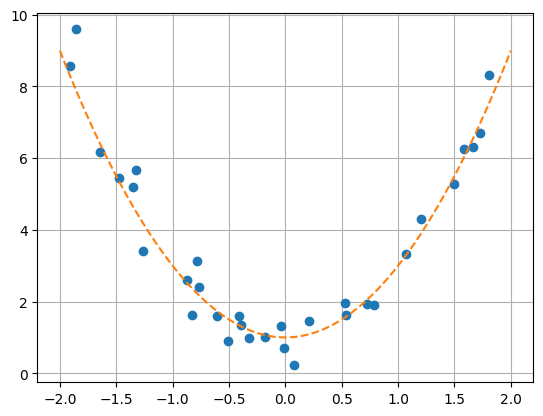

In [56]:
plt.plot(xs[:,0].detach().numpy(), ys[:,0].detach().numpy(), 'o')
plt.plot(x_eval.detach().numpy(), f(x_eval).detach().numpy(), '--')
plt.grid()
plt.show()

In [57]:
lr = 0.001
momentum = 0.9
batch_size = N//4
hidden_dim = [64, 64, 64]
loss_fn = nn.MSELoss()  
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

##### Torch BatchNorm1d

In [58]:
torch.manual_seed(1)

nn_model = MLPBN(nn.BatchNorm1d,input_dim=1, hidden_dim=hidden_dim, output_dim=1)
opt = torch.optim.SGD(nn_model.parameters(), lr=lr, momentum=momentum)

nn_model.train()
nn_losses = []
for epoch in range(100):
    for x, y in data_loader:
        preds = nn_model(x)
        loss  = loss_fn(preds, y)
        loss.backward()
        opt.step()
        opt.zero_grad()  
        nn_losses.append(loss.item())
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 9.635540008544922
Epoch 10, Loss: 3.7028627395629883
Epoch 20, Loss: 2.767793655395508
Epoch 30, Loss: 0.9286813139915466
Epoch 40, Loss: 0.210682675242424
Epoch 50, Loss: 3.2353477478027344
Epoch 60, Loss: 1.6876904964447021
Epoch 70, Loss: 0.9261752963066101
Epoch 80, Loss: 4.687756061553955
Epoch 90, Loss: 1.4742851257324219


### BatchNorm1d

In [59]:
torch.manual_seed(1)
model = MLPBN(BatchNorm1d,input_dim=1, hidden_dim=hidden_dim, output_dim=1)
opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
model.train()
losses = []

for epoch in range(100):
    for x, y in data_loader:
        preds = model(x)
        loss  = loss_fn(preds, y)
        loss.backward()
        opt.step()
        opt.zero_grad()  
        losses.append(loss.item())
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")
        

Epoch 0, Loss: 9.635539054870605
Epoch 10, Loss: 3.7028305530548096
Epoch 20, Loss: 2.7680113315582275
Epoch 30, Loss: 0.9287413358688354
Epoch 40, Loss: 0.21240173280239105
Epoch 50, Loss: 3.2518341541290283
Epoch 60, Loss: 1.6891471147537231
Epoch 70, Loss: 0.8860363364219666
Epoch 80, Loss: 4.733564853668213
Epoch 90, Loss: 1.4946062564849854


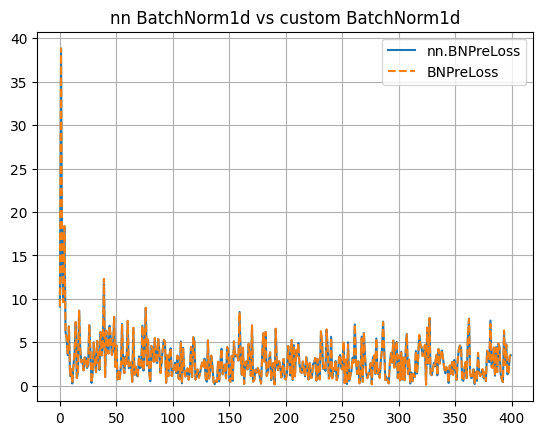

In [60]:
plt.plot(nn_losses,linestyle="-",label="nn.BNPreLoss")
plt.plot(losses,linestyle="--",label="BNPreLoss")
plt.title("nn BatchNorm1d vs custom BatchNorm1d")
plt.grid(True)
plt.legend()
plt.show()

### Evaluation

Here the diference is bigger because slighly differences in the running stimates for the mean and running have a higher impact. It globaly affect all the evaluations across the input domain

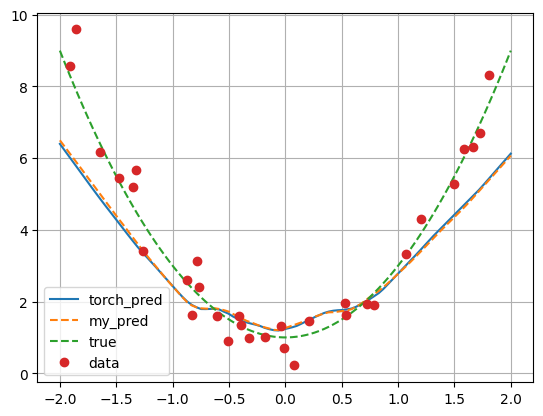

In [61]:
nn_model.eval()
model.eval()

plt.plot(x_eval,nn_model(x_eval[:,None]).squeeze().detach().numpy(), '-',label='torch_pred')
plt.plot(x_eval,model(x_eval[:,None]).squeeze().detach().numpy(), '--',label='my_pred')
plt.plot(x_eval,f(x_eval), '--',label='true')
plt.plot(xs[:,0].detach().numpy(), ys[:,0].detach().numpy(), 'o',label='data')
plt.legend()
plt.grid()
plt.show()

In [62]:
nn_model.network

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=1, out_features=64, bias=False)
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=64, bias=False)
  (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Linear(in_features=64, out_features=64, bias=False)
  (8): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU()
  (10): Linear(in_features=64, out_features=1, bias=False)
)

In [63]:
nn_batchnorms = [nn_model.network[i] for i in [2,5,8]]
for i, bn in enumerate(nn_batchnorms):
    print(f"Layer {i} - avg running mean: {bn.running_mean.mean().item():.8f}")
    print(f"Layer {i} - avg running var: {bn.running_var.mean().item():.8f}")      
    

Layer 0 - avg running mean: -0.00503542
Layer 0 - avg running var: 0.39383397
Layer 1 - avg running mean: -0.02160848
Layer 1 - avg running var: 0.39528823
Layer 2 - avg running mean: -0.11893310
Layer 2 - avg running var: 0.31631178


In [64]:
batchnorms = [model.network[i] for i in [2,5,8]]
for i, bn in enumerate(batchnorms):
    print(f"Layer {i} - avg running mean: {bn.running_mean.mean().item():.8f}")
    print(f"Layer {i} - avg running var: {bn.running_var.mean().item():.8f}")   

Layer 0 - avg running mean: -0.00503711
Layer 0 - avg running var: 0.39383662
Layer 1 - avg running mean: -0.02251817
Layer 1 - avg running var: 0.40024769
Layer 2 - avg running mean: -0.12217106
Layer 2 - avg running var: 0.32834122
